In [1]:
import os,sys
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import cPickle as pickle
import pandas as pd

In [2]:
cantera_file = ('~/Code/OOHabstraction/comparisonTST/test_performance/models/master.0.0.cti')
gas = ct.Solution(cantera_file)



**** WARNING ****
For species oh*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species ch3o2, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  11.5313
	Value computed using high-temperature polynomial: 11.5482


**** WARNING ****
For species ch*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


**** WARNING ****
For species c2h2oh, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  12.2546
	Value computed using high-temperature polynomial: 12.2718


**** WARNING ****
For species ch2co, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  10.0876
	Value computed using high-temperature polynomi

In [5]:
for species in gas.species():
    if species.composition == {'C':8,'H':18} or {"O": 1, "H":1}:
        print species.name

h
h2
o
o2
oh
oh*
h2o
n2
ho2
h2o2
ar
co
co2
ch2o
hco
ho2cho
hcoh
o2cho
hocho
ocho
hoch2o2h
hoch2o2
och2o2h
hoch2o
ch3oh
ch2oh
ch3o
ch3o2h
ch3o2
ch4
ch3
ch2
ch2(s)
c
ch
ch*
c2h6
c2h5
c2h4
c2h3
c2h2
c2h
ch3cho
c2h3oh
c2h2oh
ch3co
ch2cho
o2ch2cho
ho2ch2co
ch2co
hcco
hccoh
ch3co3h
ch3co3
ch3co2
c2h5oh
c2h5o
pc2h4oh
sc2h4oh
o2c2h4oh
c2h5o2h
c2h5o2
c2h4o2h
c2h4o1-2
c2h3o1-2
ch3coch3
ch3coch2
ch3coch2o2
c2h3cho
c2h3co
c2h5cho
c2h5co
ch3och3
ch3och2
ch3och2o2
ch2och2o2h
ch3och2o2h
ch3och2o
o2ch2och2o2h
ho2ch2ocho
och2ocho
hoch2oco
ch3ocho
ch3oco
ch2ocho
he
c3h8
ic3h7
nc3h7
c3h6
c3h5-a
c3h5-s
c3h5-t
c3h4-p
c3h4-a
c3h3
c3h5o
c3h6ooh1-2
c3h6ooh1-3
c3h6ooh2-1
c3h6ooh1-2o2
c3h6ooh1-3o2
c3h6ooh2-1o2
c3h6ooh2-2
nc3h7o2h
ic3h7o2h
nc3h7o2
ic3h7o2
nc3h7o
ic3h7o
c3h6o1-2
c3h6o1-3
c3ket12
c3ket13
c3ket21
c3h51-2,3ooh
c3h52-1,3ooh
c3h6oh
hoc3h6o2
ch3chco
ac3h5ooh
c2h3ooh
cc3h4
h2cc
c4h10
c4h8-1
c4h8-2
pc4h9
sc4h9
c4h71-1
c4h71-2
c4h71-3
c4h71-4
c4h72-2
c4h6
pc4h9o2h
sc4h9o2h
pc4h9o2
sc4h9o2
pc4h9o
sc4h9o
c4

In [4]:
def get_ignition_delay(temperature , pressure, stoichiometry=1.0, plot=False,):
    """
    Get the ignition delay at temperature (K) and pressure (bar) and stochiometry (phi),
    for the methylheptane isomer (n,2,3) mixed with a (4% O2 in Ar bath gas) mixture.
    """
    #assert isomer in ['n','s','t','i'], "Expecting isomer n,s,t, or i not {}".format(isomer)
    oxygen_mole = 1.0
    n2_mole = 79./21.*oxygen_mole
    methylheptane = stoichiometry * oxygen_mole/12.5
    X_string = 'c8h18-3:{0}, o2:{1}, n2:{2}'.format(methylheptane, oxygen_mole, n2_mole)
    gas.TPX = temperature, pressure*1e5, X_string
    reactor=ct.IdealGasReactor(gas)
    reactor_network=ct.ReactorNet([reactor])
    time=0.0
    end_time=100 # seconds!
    times=[]
    concentrations=[]
    pressures=[]
    temperatures=[]
    print_data = True
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        reactor_network.step(end_time)
    print("reached end time {0:.4f} ms in {1} steps ". format(times[-1]*1e3, len(times)))
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    
    dTdt = (temperatures[1:] - temperatures[:-1]) / (times[1:] - times[:-1])
    
    step_with_fastest_T_rise = dTdt.argmax()

    if plot:
        if step_with_fastest_T_rise>1:
            plot_until = 2e3 * times[step_with_fastest_T_rise]
            
        plt.subplot(2,1,1)
        plt.plot(times*1000,temperatures)
        plt.xlabel('time (ms)')
        plt.ylabel('temperature')
        plt.xlim(0,plot_until)
        plt.subplot(2,1,2)
        plt.plot(times[1:]*1000, dTdt)
        plt.xlabel('time (ms)')
        plt.ylabel('dT/dt')
        plt.xlim(0,plot_until)
        plt.show()
        
    
    if step_with_fastest_T_rise > 1 and step_with_fastest_T_rise < len(times)-2:
        ignition_time_ms = 1e3 * times[step_with_fastest_T_rise]
        print("At {0} K {1} bar, ignition delay time is {2} ms for 3-methylheptane".format(temperature,pressure,ignition_time_ms))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition is detected for 3-methylheptane" .format(temperature, pressure))
        return np.infty

    """
    # For excited OH emission
    i_ch=gas.species_index('ch')
    i_o2=gas.species_index('o2')
    excited_oh_generation=concentrations[:,i_o2] * concentrations[:,i_ch]
    step_with_highest_oh_gen = excited_oh_generation.argmax()
    if step_with_highest_oh_gen > 1 and excited_oh_generation.max() > 1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_oh_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature,pressure,ignition_time_ms))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition is detected" .format(temperature, pressure))
        return np.infty
    """

reached end time 106277.8847 ms in 3294 steps 


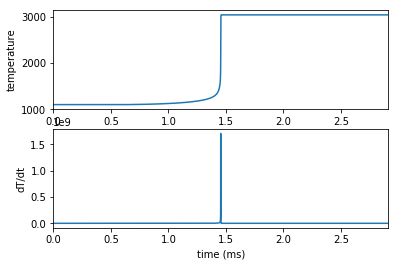

At 1100 K 10.1325 bar, ignition delay time is 1.45550786562 ms for 3-methylheptane


1.4555078656170917

In [5]:
get_ignition_delay(1100, 10*1.01325, plot=True,)

## Don't run this if you have pickle file named `3-methylheptane-delays.pkl`

In [6]:
delays_n_methylheptane = defaultdict(dict)
temperatures=list(np.arange(600.,1300.,25.))
#ignition_delay_times = np.zeros_like(temperatures)
for T in temperatures:
    P = 10 * 1.01325
    ignition_delay_times = get_ignition_delay(T, P)
    delays_n_methylheptane[T] = ignition_delay_times

reached end time 101455.7265 ms in 6073 steps 
At 600.0 K 10.1325 bar, ignition delay time is 146.709949809 ms for 3-methylheptane
reached end time 101298.2348 ms in 5825 steps 
At 625.0 K 10.1325 bar, ignition delay time is 54.7235012368 ms for 3-methylheptane
reached end time 127164.1765 ms in 5488 steps 
At 650.0 K 10.1325 bar, ignition delay time is 23.2340156835 ms for 3-methylheptane
reached end time 100720.6264 ms in 5306 steps 
At 675.0 K 10.1325 bar, ignition delay time is 11.3623032361 ms for 3-methylheptane
reached end time 101638.5347 ms in 5351 steps 
At 700.0 K 10.1325 bar, ignition delay time is 6.61949360569 ms for 3-methylheptane
reached end time 104938.3486 ms in 4980 steps 
At 725.0 K 10.1325 bar, ignition delay time is 4.83851265556 ms for 3-methylheptane
reached end time 100018.6109 ms in 5112 steps 
At 750.0 K 10.1325 bar, ignition delay time is 4.57802826024 ms for 3-methylheptane
reached end time 103945.9501 ms in 4900 steps 
At 775.0 K 10.1325 bar, ignition del

In [7]:
#with open('3-methylheptane-delays.pkl','w') as outfile:
    #pickle.dump(delays_n_methylheptane,outfile)

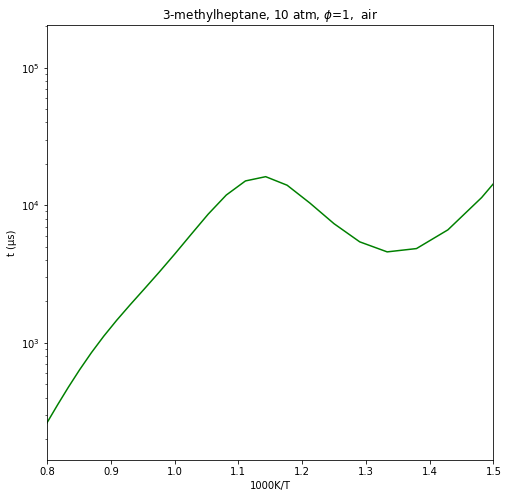

In [12]:
plt.subplots(figsize=(8,8))

plt.semilogy(1000/np.array(temperatures), [1000*delays_n_methylheptane[T] for T in temperatures], 'g-')
plt.xlim(0.8,1.5)
#plt.ylim(10,10e3)
plt.ylabel(u't (µs)')
plt.xlabel('1000K/T')
plt.title('3-methylheptane, 10 atm, $\phi$=1,  air')

plt.show()